In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import signal
from scipy.optimize import curve_fit
import os

In [29]:
def load_fits_data(filename):
    with fits.open(filename) as hdul:
        data = hdul[1].data
        time = data['TIME'] + hdul[1].header['BJDREFI'] + hdul[1].header['BJDREFF']
        flux = data['PDCSAP_FLUX']
        flux_err = data['PDCSAP_FLUX_ERR']
    mask = ~(np.isnan(time) | np.isnan(flux) | np.isnan(flux_err))
    return time[mask], flux[mask], flux_err[mask]

def period_calc(midtimes):
    midtimes = np.sort(np.array(midtimes))
    n = len(midtimes)
    if n < 2:
        return np.nan, np.nan
    time_diffs = []
    for i in range(n):
        for j in range(i+1, n):
            dt = midtimes[j] - midtimes[i]
            time_diffs.append(dt)
    time_diffs = np.array(time_diffs)
    candidate_periods = []
    min_diff = np.min(time_diffs)
    candidate_periods.append(min_diff)
    max_multiplier = min(10, n)
    for diff in time_diffs:
        for k in range(1, max_multiplier + 1):
            candidate_period = diff / k
            if candidate_period > 0.1:
                candidate_periods.append(candidate_period)
    candidate_periods = np.array(candidate_periods)
    best_period = None
    best_score = -1
    tolerance = 0.05
    
    for period in candidate_periods:
        if period <= 0:
            continue
            
        matches = 0
        residuals = []
        for diff in time_diffs:
            n_periods = np.round(diff / period)
            if n_periods > 0:
                expected_diff = n_periods * period
                relative_error = abs(diff - expected_diff) / expected_diff
                if relative_error < tolerance:
                    matches += 1
                    residuals.append(abs(diff - expected_diff))
        
        if matches > 0:
            score = matches - np.mean(residuals) if residuals else matches
            if score > best_score:
                best_score = score
                best_period = period
    if best_period is None:
        if n >= 2:
            periods = []
            for i in range(n-1):
                periods.append(midtimes[i+1] - midtimes[i])
            best_period = np.median(periods)
        else:
            return np.nan, np.nan

    residuals = []
    for diff in time_diffs:
        n_periods = np.round(diff / best_period)
        if n_periods > 0:
            expected_diff = n_periods * best_period
            residuals.append(abs(diff - expected_diff))
    if residuals:
        period_err = np.std(residuals) / np.sqrt(len(residuals))
    else:
        all_period_estimates = []
        for diff in time_diffs:
            for k in range(1, max_multiplier + 1):
                if abs(diff/k - best_period) / best_period < tolerance:
                    all_period_estimates.append(diff/k)
        if all_period_estimates:
            period_err = np.std(all_period_estimates)
        else:
            period_err = best_period * 0.1
    return best_period, period_err

def normalize_flux(time, flux, flux_err):
    def linear_func(t, a, b):
        return a*t + b
    try:
        popt, _ = curve_fit(linear_func, time, flux, sigma=flux_err)
    except:
        popt, _ = curve_fit(linear_func, time, flux)
    
    trend_initial = linear_func(time, *popt)
    residuals = flux - trend_initial
    mad_residual = np.median(np.abs(residuals - np.median(residuals)))
    outlier_mask = np.abs(residuals - np.median(residuals)) < 3 * mad_residual * 1.4826
    try:
        popt_final, _ = curve_fit(linear_func, time[outlier_mask], flux[outlier_mask], 
                                sigma=flux_err[outlier_mask])
    except:
        popt_final, _ = curve_fit(linear_func, time[outlier_mask], flux[outlier_mask])
    trend = linear_func(time, *popt_final)
    normalized_flux = flux / trend
    normalized_flux_err = flux_err / trend
    return normalized_flux, normalized_flux_err, trend

def detect_transits(time, normalized_flux):
    window_size = min(51, len(normalized_flux) // 10)
    if window_size % 2 == 0:
        window_size += 1
    if len(normalized_flux) > window_size:
        smoothed_flux = signal.savgol_filter(normalized_flux, window_size, 3)
    else:
        smoothed_flux = normalized_flux
    baseline = np.median(smoothed_flux[smoothed_flux > 0.994])
    depth_threshold = baseline * 0.994
    dip_mask = smoothed_flux < depth_threshold
    if not np.any(dip_mask):
        print("No significant dips found. Trying with lower threshold...")
        depth_threshold = baseline * 0.995
        dip_mask = smoothed_flux < depth_threshold
    dip_indices = np.where(dip_mask)[0]
    if len(dip_indices) == 0:
        return np.array([]), {}
    transit_groups = []
    current_group = [dip_indices[0]]
    for i in range(1, len(dip_indices)):
        if dip_indices[i] - dip_indices[i-1] <= 5:
            current_group.append(dip_indices[i])
        else:
            if len(current_group) >= 3:
                transit_groups.append(current_group)
            current_group = [dip_indices[i]]
    if len(current_group) >= 3:
        transit_groups.append(current_group)
    transit_centers = []
    for group in transit_groups:
        group_fluxes = smoothed_flux[group]
        deepest_idx = group[np.argmin(group_fluxes)]
        transit_centers.append(deepest_idx)
    transit_centers = np.array(transit_centers)
    print(f"Found {len(transit_centers)} transit candidates")
    properties = {'peak_heights': baseline - smoothed_flux[transit_centers],
                  'widths': np.full(len(transit_centers), 10.0)}
    return transit_centers

def calculate_transit_properties(time, flux, midtime_idx, window_hours=24):
    midtime = time[midtime_idx]
    half_window = (window_hours / 2) / 24.0
    mask = (time >= midtime - half_window) & (time <= midtime + half_window)
    t_transit = time[mask]
    f_transit = flux[mask]
    if len(t_transit) < 5:
        return None, None
    baseline = np.median(f_transit)
    min_flux = np.min(f_transit)
    depth = (baseline - min_flux) / baseline
    threshold = baseline - 0.5 * (baseline - min_flux)
    below_threshold = f_transit < threshold
    if not np.any(below_threshold):
        duration = 0
    else:
        diff_indices = np.diff(np.where(below_threshold)[0])
        if len(diff_indices) == 0:
            duration = (t_transit[below_threshold][-1] - t_transit[below_threshold][0]) * 24
        else:
            gaps = np.where(diff_indices > 1)[0]
            if len(gaps) == 0:
                duration = (t_transit[below_threshold][-1] - t_transit[below_threshold][0]) * 24
            else:
                segments = np.split(np.where(below_threshold)[0], gaps + 1)
                longest_segment = max(segments, key=len)
                if len(longest_segment) > 1:
                    duration = (t_transit[longest_segment[-1]] - t_transit[longest_segment[0]]) * 24
                else:
                    duration = 0
    return depth, duration

def filter_anomalous_transits(time, flux, transit_indices, depth_sigma=2.5, duration_sigma=2.5):
    if len(transit_indices) < 3:
        print("Too few transits for statistical filtering")
        return transit_indices
    depths = []
    durations = []
    valid_transits = []
    for idx in transit_indices:
        depth, duration = calculate_transit_properties(time, flux, idx)
        if depth is not None and duration is not None and depth > 0 and duration > 0:
            depths.append(depth)
            durations.append(duration)
            valid_transits.append(idx)
    
    if len(valid_transits) < 3:
        print("Too few valid transits after initial filtering")
        return np.array(valid_transits)
    depths = np.array(depths)
    durations = np.array(durations)
    median_depth = np.median(depths)
    mad_depth = np.median(np.abs(depths - median_depth))
    depth_std = 1.4826 * mad_depth
    median_duration = np.median(durations)
    mad_duration = np.median(np.abs(durations - median_duration))
    duration_std = 1.4826 * mad_duration
    print(f"Transit statistics:")
    print(f"  Depth: {median_depth:.4f} ± {depth_std:.4f}")
    print(f"  Duration: {median_duration:.2f} ± {duration_std:.2f} hours")
    depth_outliers = np.abs(depths - median_depth) > depth_sigma * depth_std
    duration_outliers = np.abs(durations - median_duration) > duration_sigma * duration_std
    outlier_mask = depth_outliers | duration_outliers
    good_transits = np.array(valid_transits)[~outlier_mask]
    rejected_transits = np.array(valid_transits)[outlier_mask]
    print(f"Filtered transits:")
    print(f"  Original: {len(transit_indices)}")
    print(f"  Valid properties: {len(valid_transits)}")
    print(f"  After filtering: {len(good_transits)}")
    print(f"  Rejected: {len(rejected_transits)}")
    if len(rejected_transits) > 0:
        print("Rejected transit details:")
        for i, idx in enumerate(rejected_transits):
            orig_pos = np.where(np.array(valid_transits) == idx)[0][0]
            print(f"  Transit at index {idx}: depth={depths[orig_pos]:.4f}, duration={durations[orig_pos]:.2f}h")
    return good_transits

def extract_and_save_transits(time, norm_flux, flux_err, mid_indices, window_hours, output_dir):  ###################
    os.makedirs(output_dir, exist_ok=True)
    half_days = (window_hours / 2) / 24.0
    baseline = np.median(norm_flux)
    dip_threshold = np.percentile(norm_flux, 10)
    midtimes_list = []
    for i, idx in enumerate(mid_indices, start=1):
        det_mid = time[idx]
        mask0 = (time >= det_mid - half_days) & (time <= det_mid + half_days)
        t0 = time[mask0]
        f0 = norm_flux[mask0]
        e0 = flux_err[mask0]
        dip_mask = f0 < dip_threshold
        if not np.any(dip_mask):
            true_mid = det_mid
        else:
            dip_indices = np.where(dip_mask)[0]
            diffs = np.diff(dip_indices)
            groups = np.split(dip_indices, np.where(diffs > 1)[0]+1)
            main_seg = max(groups, key=len)
            true_start = t0[main_seg[0]]
            true_end = t0[main_seg[-1]]
            true_mid = 0.5 * (true_start + true_end)
        midtimes_list.append(true_mid)
    period, period_err = period_calc(midtimes_list)
    for i, idx in enumerate(mid_indices, start=1):
        det_mid = time[idx]
        mask0 = (time >= det_mid - half_days) & (time <= det_mid + half_days)
        t0 = time[mask0]
        f0 = norm_flux[mask0]
        e0 = flux_err[mask0]
        dip_mask = f0 < dip_threshold
        if not np.any(dip_mask):
            true_mid = det_mid
        else:
            dip_indices = np.where(dip_mask)[0]
            diffs = np.diff(dip_indices)
            groups = np.split(dip_indices, np.where(diffs > 1)[0]+1)
            main_seg = max(groups, key=len)
            true_start = t0[main_seg[0]]
            true_end = t0[main_seg[-1]]
            true_mid = 0.5 * (true_start + true_end)
        final_mask = (time >= true_mid - half_days) & (time <= true_mid + half_days)
        t1 = time[final_mask]
        f1 = norm_flux[final_mask]
        e1 = flux_err[final_mask]
        fname = os.path.join(output_dir, f'transit_{i:02d}.txt')
        with open(fname, 'w') as f:
            f.write(f"# Transit {i}\n")
            f.write(f"# Period (BJD): {period:.8f}\n")
            f.write(f"# Error Period (BJD): {period_err:.8f}\n")
            f.write(f"# True midtime (BJD): {true_mid:.8f}\n")
            f.write(f"# Window ±{window_hours/2:.2f} hours around true midtime\n")
            f.write("# Columns: time_BJD - flux_norm - flux_err_norm\n")
            for tt, fl, er in zip(t1, f1, e1):
                f.write(f"{tt:.8f} {fl:.6f} {er:.6f}\n")
        print(f"Saved transit {i}: start {t1.min():.6f}, end {t1.max():.6f}, mid {true_mid:.6f} -> {fname}")

def plot_transit_comparison(time, flux, all_transits, good_transits, rejected_transits):
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.plot(time, flux, 'k.', alpha=0.3, markersize=1)
    for idx in all_transits:
        plt.axvline(time[idx], color='red', alpha=0.5, linestyle=':', label='All detected' if idx == all_transits[0] else "")
    for idx in good_transits:
        plt.axvline(time[idx], color='green', alpha=0.8, linewidth=2, label='Good transits' if idx == good_transits[0] else "")
    for idx in rejected_transits:
        plt.axvline(time[idx], color='red', alpha=0.8, linewidth=2, label='Rejected' if idx == rejected_transits[0] else "")
    
    plt.xlabel('Time (BJD)')
    plt.ylabel('Normalized Flux')
    plt.title('Transit Detection and Filtering Results')
    plt.legend()
    plt.grid(alpha=0.3)
    if len(rejected_transits) > 0:
        plt.subplot(2, 1, 2)
        colors = ['red', 'orange', 'purple', 'brown']
        for i, idx in enumerate(rejected_transits[:4]):
            window = 0.1
            mask = (time >= time[idx] - window) & (time <= time[idx] + window)
            offset = i * 0.02
            plt.plot(time[mask], flux[mask] - offset, 'o-', color=colors[i % len(colors)], 
                    markersize=3, alpha=0.7, label=f'Rejected transit {i+1}')
            plt.axvline(time[idx], color=colors[i % len(colors)], linestyle='--', alpha=0.7)
        plt.xlabel('Time (BJD)')
        plt.ylabel('Normalized Flux (with offsets)')
        plt.title('Rejected Transits (Close-up)')
        plt.legend()
        plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def read_transit_txt(filename):
    data = np.loadtxt(filename, comments='#')
    time = data[:,0]
    flux = data[:,1]
    flux_err = data[:,2]
    midtime = None
    period = None
    with open(filename) as f:
        for line in f:
            if line.startswith('# True midtime'):
                midtime = float(line.split(':')[1])
            if line.startswith('# Period'):
                period = float(line.split(':')[1])
    return period, midtime, time, flux, flux_err

def plot_transit_from_txt(filename):
    period, midtime, time, flux, flux_err = read_transit_txt(filename)
    plt.errorbar(time, flux, yerr=flux_err, fmt='o', markersize=4, capsize=2)
    plt.axvline(midtime, color='red', linestyle='--', label='Midtime')
    plt.xlabel('Time (BJD)')
    plt.ylabel('Normalized Flux')
    title = f"Transit at {midtime:.5f}"
    if period:
        title += f" | Period: {period:.5f} d"
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

def validate_period_calculation(midtimes, period, period_err, plot=True):
    midtimes = np.sort(np.array(midtimes))
    n = len(midtimes)
    if n < 2:
        print("Not enough transits for period validation")
        return
    print(f"\nPeriod Validation:")
    print(f"Calculated Period: {period:.6f} ± {period_err:.6f} days")
    print(f"Number of transits: {n}")
    epoch = midtimes[0]
    expected_times = []
    cycle_numbers = []
    residuals = []
    for i, midtime in enumerate(midtimes):
        cycle_float = (midtime - epoch) / period
        cycle_int = np.round(cycle_float)
        cycle_numbers.append(int(cycle_int))
        expected_time = epoch + cycle_int * period
        expected_times.append(expected_time)
        residual = (midtime - expected_time) * 24 * 60
        residuals.append(residual)
        print(f"Transit {i+1}: Observed={midtime:.6f}, Expected={expected_time:.6f}, "
              f"Cycle={int(cycle_int)}, Residual={residual:.2f} min")
    residuals = np.array(residuals)
    rms_residual = np.sqrt(np.mean(residuals**2))
    print(f"RMS residual: {rms_residual:.2f} minutes")
    cycle_numbers = np.array(cycle_numbers)
    expected_cycles = np.arange(cycle_numbers.min(), cycle_numbers.max() + 1)
    missing_cycles = np.setdiff1d(expected_cycles, cycle_numbers)
    if len(missing_cycles) > 0:
        print(f"Missing transit cycles: {missing_cycles}")
        print("This confirms that some transits were filtered out from the sequence.")
    else:
        print("No missing cycles detected - all transits in sequence are present.")
    if plot and len(midtimes) > 2:
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 2, 1)
        plt.plot(cycle_numbers, midtimes, 'bo', label='Observed', markersize=8)
        plt.plot(cycle_numbers, expected_times, 'ro', label='Expected', markersize=6)
        plt.xlabel('Cycle Number')
        plt.ylabel('Midtime (BJD)')
        plt.title('Observed vs Expected Midtimes')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.subplot(2, 2, 2)
        plt.plot(cycle_numbers, residuals, 'go', markersize=8)
        plt.axhline(0, color='red', linestyle='--', alpha=0.7)
        plt.xlabel('Cycle Number')
        plt.ylabel('Residual (minutes)')
        plt.title(f'Timing Residuals (RMS = {rms_residual:.2f} min)')
        plt.grid(alpha=0.3)
        plt.subplot(2, 2, 3)
        phases = ((midtimes - epoch) % period) / period
        plt.plot(phases, np.ones_like(phases), 'ko', markersize=8)
        plt.xlim(0, 1)
        plt.xlabel('Phase')
        plt.ylabel('Transit Events')
        plt.title('Phase-folded Transit Times')
        plt.grid(alpha=0.3)
        plt.subplot(2, 2, 4)
        if n > 1:
            time_diffs = np.diff(midtimes)
            cycle_diffs = np.diff(cycle_numbers)
            expected_diffs = cycle_diffs * period
            plt.plot(range(1, len(time_diffs)+1), time_diffs, 'bo-', label='Observed Δt', markersize=6)
            plt.plot(range(1, len(expected_diffs)+1), expected_diffs, 'ro-', label='Expected Δt', markersize=6)
            plt.xlabel('Transit Pair')
            plt.ylabel('Time Difference (days)')
            plt.title('Consecutive Time Differences')
            plt.legend()
            plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

def main(fits_file, window_hours, depth_sigma=2.5, duration_sigma=2.5, plot_results=True, validate_period=True, directory = None):
    time, flux, flux_err = load_fits_data(fits_file)
    norm_flux, norm_err, _ = normalize_flux(time, flux, flux_err)
    all_transit_indices = detect_transits(time, norm_flux)
    if len(all_transit_indices) == 0:
        print("No transits detected!")
        return
    good_transit_indices = filter_anomalous_transits(time, norm_flux, all_transit_indices, depth_sigma=depth_sigma, duration_sigma=duration_sigma)
    if len(good_transit_indices) == 0:
        print("No good transits remaining after filtering!")
        return
    if plot_results:
        rejected_indices = np.setdiff1d(all_transit_indices, good_transit_indices)
        plot_transit_comparison(time, norm_flux, all_transit_indices, good_transit_indices, rejected_indices)
    extract_and_save_transits(time, norm_flux, norm_err, good_transit_indices, window_hours, output_dir=directory)
    if len(good_transit_indices) >= 2:
        final_midtimes = []
        half_days = (window_hours / 2) / 24.0
        dip_threshold = np.percentile(norm_flux, 10)
        for idx in good_transit_indices:
            det_mid = time[idx]
            mask0 = (time >= det_mid - half_days) & (time <= det_mid + half_days)
            t0 = time[mask0]
            f0 = norm_flux[mask0]
            dip_mask = f0 < dip_threshold
            if not np.any(dip_mask):
                true_mid = det_mid
            else:
                dip_indices = np.where(dip_mask)[0]
                diffs = np.diff(dip_indices)
                groups = np.split(dip_indices, np.where(diffs > 1)[0]+1)
                main_seg = max(groups, key=len)
                true_start = t0[main_seg[0]]
                true_end = t0[main_seg[-1]]
                true_mid = 0.5 * (true_start + true_end)
            final_midtimes.append(true_mid)
        final_period, final_period_err = period_calc(final_midtimes)
        print(f"\n" + "="*60)
        print(f"FINAL RESULTS:")
        print(f"="*60)
        print(f"Transits detected: {len(all_transit_indices)}")
        print(f"Transits saved: {len(good_transit_indices)}")
        print(f"Transits rejected: {len(all_transit_indices) - len(good_transit_indices)}")
        print(f"")
        print(f"ORBITAL PERIOD:")
        print(f"Period = {final_period:.8f} ± {final_period_err:.8f} days")
        print(f"Period = {final_period*24:.6f} ± {final_period_err*24:.6f} hours")
        print(f"Period = {final_period*24*60:.4f} ± {final_period_err*24*60:.4f} minutes")
        print(f"="*60)
    else:
        print(f"\nFinal results: {len(good_transit_indices)} good transits saved from {len(all_transit_indices)} detected")
        print("Not enough transits for period calculation (need at least 2)")

Found 7 transit candidates
Transit statistics:
  Depth: 0.0139 ± 0.0004
  Duration: 2.80 ± 0.10 hours
Filtered transits:
  Original: 7
  Valid properties: 7
  After filtering: 7
  Rejected: 0


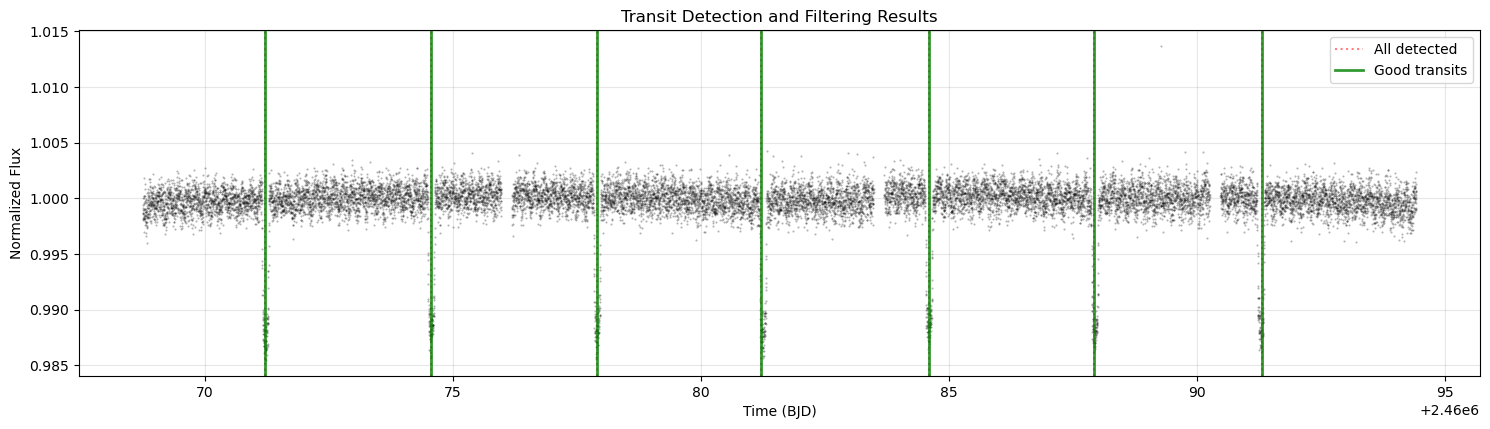

Saved transit 1: start 2460071.008524, end 2460071.423809, mid 2460071.216166 -> KELT-26b\transit_01.txt
Saved transit 2: start 2460074.354405, end 2460074.769687, mid 2460074.562046 -> KELT-26b\transit_02.txt
Saved transit 3: start 2460077.697495, end 2460078.112777, mid 2460077.905136 -> KELT-26b\transit_03.txt
Saved transit 4: start 2460081.043354, end 2460081.457245, mid 2460081.250300 -> KELT-26b\transit_04.txt
Saved transit 5: start 2460084.386420, end 2460084.803085, mid 2460084.594753 -> KELT-26b\transit_05.txt
Saved transit 6: start 2460087.730843, end 2460088.147506, mid 2460087.939174 -> KELT-26b\transit_06.txt
Saved transit 7: start 2460091.078030, end 2460091.494691, mid 2460091.286361 -> KELT-26b\transit_07.txt

FINAL RESULTS:
Transits detected: 7
Transits saved: 7
Transits rejected: 0

ORBITAL PERIOD:
Period = 3.34471103 ± 0.00017468 days
Period = 80.273065 ± 0.004192 hours
Period = 4816.3839 ± 0.2515 minutes


In [30]:
main('tess2023124020739-s0065-0000000160708862-0259-s_lc.fits', window_hours=10, validate_period=True, directory = 'KELT-26b')

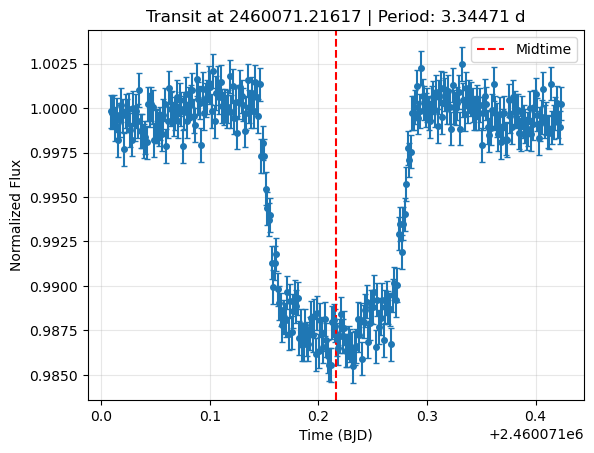

In [32]:
period, mid, t, f, e = read_transit_txt('KELT-26b/transit_01.txt')
plot_transit_from_txt('KELT-26b/transit_01.txt')